**Introduction**
-----------------------------
The dataframe consists of **162421 complaints** for **5 products**. The dataframe is considerably imbalanced.

The notebook implements Bi-LSTM model for multiclass classification of product complaints. Based on the provided complaints, the goal of the notebook is to accurately identify the product.

In [47]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.python.client import device_lib
tf.test.gpu_device_name()

''

# Reading and Analysing DataFrame

In [48]:
df= pd.read_csv('../input/consume-complaints-dataset-fo-nlp/complaints_processed.csv')
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [49]:
df = df.rename(columns={'narrative':'tweet' })
df = df.drop("Unnamed: 0",axis =1)
df.head()

,product,tweet
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [50]:
# Removing NaNs
df = df.dropna(subset=['tweet'])
print('NaNs are removed from the dataframe. Number of NaNs can be confirmed to be {}. The size of dataframe has reduced to {}'.format(df['tweet'].isnull().sum(), df.shape))

NaNs are removed from the dataframe. Number of NaNs can be confirmed to be 0. The size of dataframe has reduced to (162411, 2)


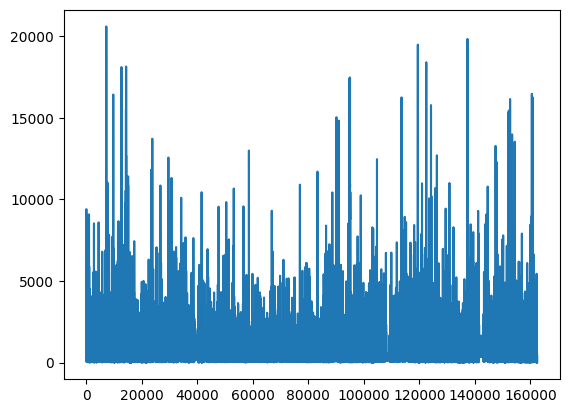

In [51]:
# Plotting word lenghts of tweets
word_length = [len(x) for x in df['tweet']]
plt.plot(word_length)

In [52]:
# Converting sentences to string
df['tweet'] = df['tweet'].astype(str)

In [53]:
# Types of products
df['product'].value_counts()

product
credit_reporting       91172
debt_collection        23148
mortgages_and_loans    18990
credit_card            15566
retail_banking         13535
Name: count, dtype: int64

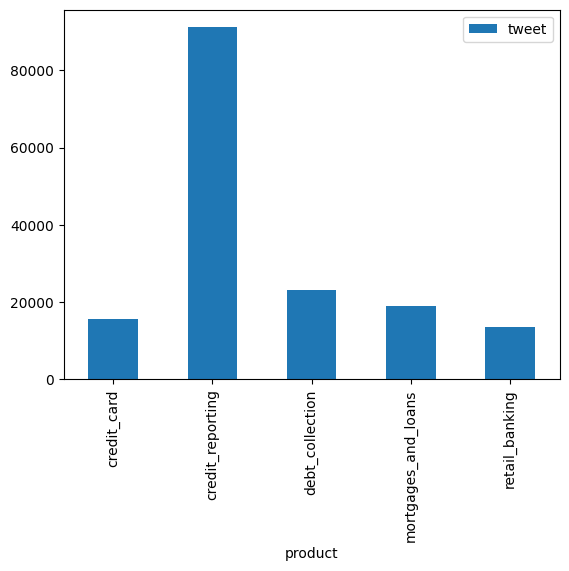

In [13]:
# Plotting product value counts
df.groupby('product').count().plot(kind='bar')
plt.show()

Dataframe is **imbalanced**. Improving the balance of the dataframe can improve accuracy.

# Train-Test Splitting

In [54]:
# Importing train test splilt library 
from sklearn.model_selection import train_test_split

# Train-Test Splitting
train_data, test_data = train_test_split(df, test_size = 0.20)

In [55]:
# Train and test data dimensions
train_data.shape, test_data.shape

((129928, 2), (32483, 2))

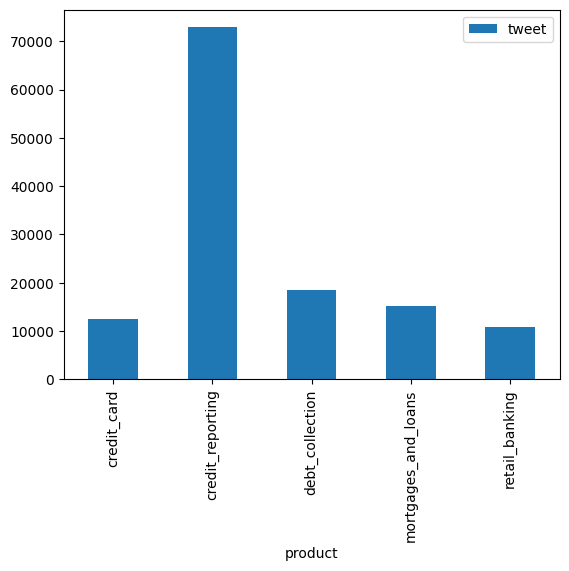

In [56]:
# Balance of train data
train_data.groupby('product').count().plot(kind='bar')
plt.show()

* credit_card, debt_collection, mortgages_and_loans, retail_banking columns consist of very few values. So, the values in these columns will be increased using random oversampling.
* Oversampling is done in train set because this will prevent data leakage to test set.

# Random Oversampling

In [57]:
# Train set value counts 
train_data.groupby('product').count()

,tweet
product,
credit_card,12496
credit_reporting,72896
debt_collection,18495
mortgages_and_loans,15278
retail_banking,10763


In [58]:
# Randomly selecting 7000 indices in classes with low value count
import numpy as np
to_add_1 = np.random.choice(train_data[train_data['product']=='credit_card'].index,size = 7000,replace=False)   
to_add_2 = np.random.choice(train_data[train_data['product']=='debt_collection'].index,size = 7000,replace=False) 
to_add_3 = np.random.choice(train_data[train_data['product']=='mortgages_and_loans'].index,size = 7000,replace=False)  
to_add_4 = np.random.choice(train_data[train_data['product']=='retail_banking'].index,size=7000,replace=False)

# Indices to be added
to_add = np.concatenate((to_add_1, to_add_2, to_add_3, to_add_4 ))
len(to_add)

28000

In [59]:
# Forming a dataframe for randomly selected indices
df_replicate = train_data[train_data.index.isin(to_add)]
df_replicate  

,product,tweet
15594,debt_collection,debt owed proof debt owed correspondence creditor
16534,credit_card,due job related derivative condition made fly ...
116724,retail_banking,submitted claim usaa federal saving bank fraud...
2669,debt_collection,according resurgent capital reporting three bu...
52908,retail_banking,using money lending company called help financ...
...,...,...
117956,debt_collection,ordered lab test primary doctor lab company bi...
97394,retail_banking,cash app account locked friend tried send mone...
35764,credit_card,began receiving charge chase visa card back re...
12911,retail_banking,consumer financial protection bureau please al...


In [60]:
# Concatenating replicated df to orinigal df
train_data = pd.concat([train_data, df_replicate])
train_data['product'].value_counts()

product
credit_reporting       72896
debt_collection        25495
mortgages_and_loans    22278
credit_card            19496
retail_banking         17763
Name: count, dtype: int64

Value counts of **minority classes have increased**.

# Text Preprocessing

In [41]:
stop_words = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
    "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
    'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
    'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
    'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were',
    'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because',
    'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about',
    'against', 'between', 'into', 'through', 'during', 'before', 'after',
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
    'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there',
    'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few',
    'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',
    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will',
    'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm',
    'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
    "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
    "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
    'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won',
    "won't", 'wouldn', "wouldn't"
}


In [61]:
# Declaring function for text preprocessing 

def preprocess_text(main_df):
  df_1 = main_df.copy()
  df_1['tweet'] = df_1['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words)) 
   
  # remove punctuations and convert to lower case
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
  
  # remove double spaces
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub(' ', ' ', x))

  return df_1 

In [62]:
# Preprocessing training and test data 
train_data = preprocess_text(train_data)
test_data = preprocess_text(test_data)

In [63]:
# Verifying text preprocessing
train_data['tweet'].head()

94705     last first getting response fax request last e...
50351     bbva visa card one year month wife individual ...
104887    thursday received phone call collection agency...
32413     legal power attorney received numerous call ea...
139796    first time encountered identity theft idea cou...
Name: tweet, dtype: object

# Label Encoding

In [65]:
# Declaring train labels
train_labels = train_data['product'] 
test_labels = test_data['product']

In [66]:
# Converting labels to numerical features
import numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
test_labels = le.transform(test_labels)

print(le.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

['credit_card' 'credit_reporting' 'debt_collection' 'mortgages_and_loans'
 'retail_banking']
(array([0, 1, 2, 3, 4]), array([19496, 72896, 25495, 22278, 17763]))
(array([0, 1, 2, 3, 4]), array([ 3070, 18276,  4653,  3712,  2772]))


In [67]:
# Changing labels to categorical features
import numpy as np
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import numpy as np

train_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.array(test_labels))

# Tokenizing Sentences and Fixing Sentence Length

In [68]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Defining training parameters
max_sequence_length = 170   
max_words = 2500   

# Tokenizing tweets/sentences wrt num_words
tokenizer = Tokenizer(num_words = max_words)  # Selects most frequent words 
tokenizer.fit_on_texts(train_data.tweet)      # Develops internal vocab based on training text
train_sequences = tokenizer.texts_to_sequences(train_data.tweet)  # converts text to sequence

test_sequences = tokenizer.texts_to_sequences(test_data.tweet)

In [69]:
# Fixing the sequence length 
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_data = pad_sequences(train_sequences, maxlen = max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen = max_sequence_length)
train_data.shape, test_data.shape

((157928, 170), (32483, 170))

# Bi-LSTM Model

In [70]:
# Model Parameters
embedding_dim = 32 

# Importing Libraries
import tensorflow as tf
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding 

In [71]:
embedding_dim = 32  

# Model Training
model = Sequential()
model.add(Embedding(max_words, 
                   embedding_dim,
                   input_length=max_sequence_length))

# Bidirectional LSTM 
model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.4, recurrent_dropout=0)))   

model.add(GlobalMaxPool1D())

model.add(Dense(5,activation='softmax'))  

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Passing Data Through Network

In [72]:
model.compile(loss = 'binary_crossentropy', optimizer='RMSProp', metrics = ['accuracy'])

In [73]:
# declaring weights of product categories
class_weight = {0: 4,          
                1: 5,    
                2: 3,      
                3: 3,     
                4: 4}      

# training and validating model 
history = model.fit(train_data, train_labels, batch_size=48, epochs= 20, class_weight = class_weight, validation_data=(test_data, test_labels)) # best 89(now) or 48 or 60 epochs # default epochs = 23 # batch_size changed to 1 (takes 2.30hrs) from 16

Epoch 1/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 352s 105ms/step - accuracy: 0.6332 - loss: 1.2114 - val_accuracy: 0.8497 - val_loss: 0.1561
Epoch 2/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 348s 106ms/step - accuracy: 0.8476 - loss: 0.6053 - val_accuracy: 0.8643 - val_loss: 0.1440
Epoch 3/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 349s 106ms/step - accuracy: 0.8592 - loss: 0.5615 - val_accuracy: 0.8698 - val_loss: 0.1386
Epoch 4/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 348s 106ms/step - accuracy: 0.8609 - loss: 0.5492 - val_accuracy: 0.8705 - val_loss: 0.1370
Epoch 5/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 323s 98ms/step - accuracy: 0.8662 - loss: 0.5324 - val_accuracy: 0.8708 - val_loss: 0.1363
Epoch 6/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 307s 93ms/step - accuracy: 0.8679 - loss: 0.5242 - val_accuracy: 0.8700 - val_loss: 0.1361
Epoch 7/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 348s 106ms/step - accuracy: 0.8698 - loss: 0.5178 - val_accuracy: 0.8725 - val_loss: 0.1336
Epoch 8/20
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 334s 101ms/step - accu

In [74]:
# Prediction on Test Data
predicted_bi_lstm = model.predict(test_data)
predicted_bi_lstm

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step


array([[4.3002628e-06, 9.9998659e-01, 3.3967954e-06, 5.1315641e-07,
        5.2706469e-06],
       [7.4065829e-05, 9.9961466e-01, 2.7571514e-04, 1.5051360e-05,
        2.0445930e-05],
       [4.0575560e-05, 3.5841735e-03, 1.8650591e-02, 9.7739047e-01,
        3.3417935e-04],
       ...,
       [9.6400052e-01, 2.0993130e-02, 2.6651437e-03, 9.8706912e-03,
        2.4705573e-03],
       [7.7164042e-01, 8.3096223e-03, 3.1325556e-03, 2.1237330e-01,
        4.5441892e-03],
       [3.9466188e-04, 9.7862005e-01, 2.0294718e-02, 6.7476078e-04,
        1.5705504e-05]], dtype=float32)

# Model Evaluation

In [75]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(test_labels, predicted_bi_lstm.round())

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('----------------------------------------------')
print(sklearn.metrics.classification_report(test_labels, predicted_bi_lstm.round()))

precision: [0.78340276 0.91953277 0.83444692 0.84700359 0.86268973]
recall: [0.79641694 0.93040053 0.72469375 0.82623922 0.88167388]
fscore: [0.78985624 0.92493473 0.77570738 0.83649257 0.8720785 ]
support: [ 3070 18276  4653  3712  2772]
----------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      3070
           1       0.92      0.93      0.92     18276
           2       0.83      0.72      0.78      4653
           3       0.85      0.83      0.84      3712
           4       0.86      0.88      0.87      2772

   micro avg       0.88      0.87      0.88     32483
   macro avg       0.85      0.83      0.84     32483
weighted avg       0.88      0.87      0.88     32483
 samples avg       0.87      0.87      0.87     32483



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Performance with Epochs

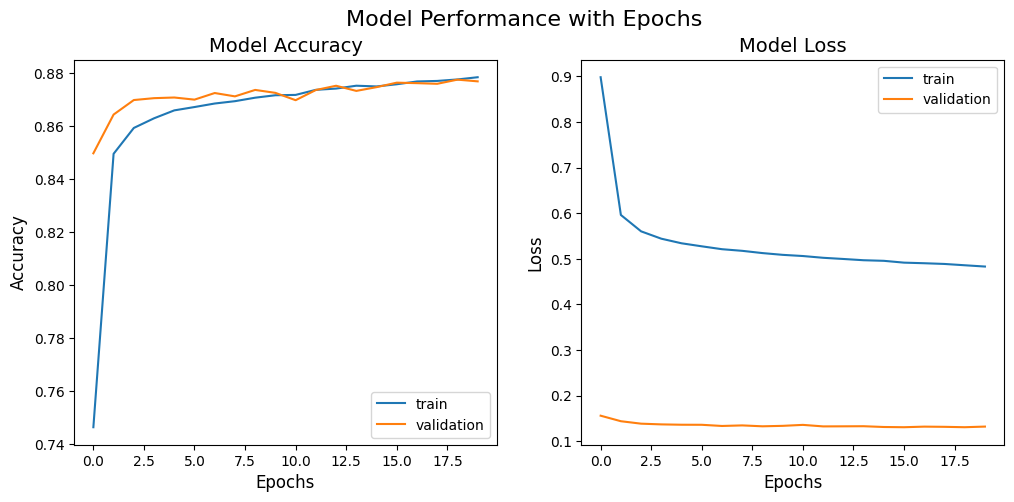

In [76]:
def accuracy_plot(history):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    fig.suptitle('Model Performance with Epochs', fontsize = 16)
    # Subplot 1 
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy', fontsize = 14)
    ax[0].set_xlabel('Epochs', fontsize = 12)
    ax[0].set_ylabel('Accuracy', fontsize = 12)
    ax[0].legend(['train', 'validation'], loc='best')

# Subplot 2
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss', fontsize = 14)
    ax[1].set_xlabel('Epochs', fontsize = 12)
    ax[1].set_ylabel('Loss', fontsize = 12)
    ax[1].legend(['train', 'validation'], loc='best')
    
    
accuracy_plot(history)

# Confusion Matrix

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step


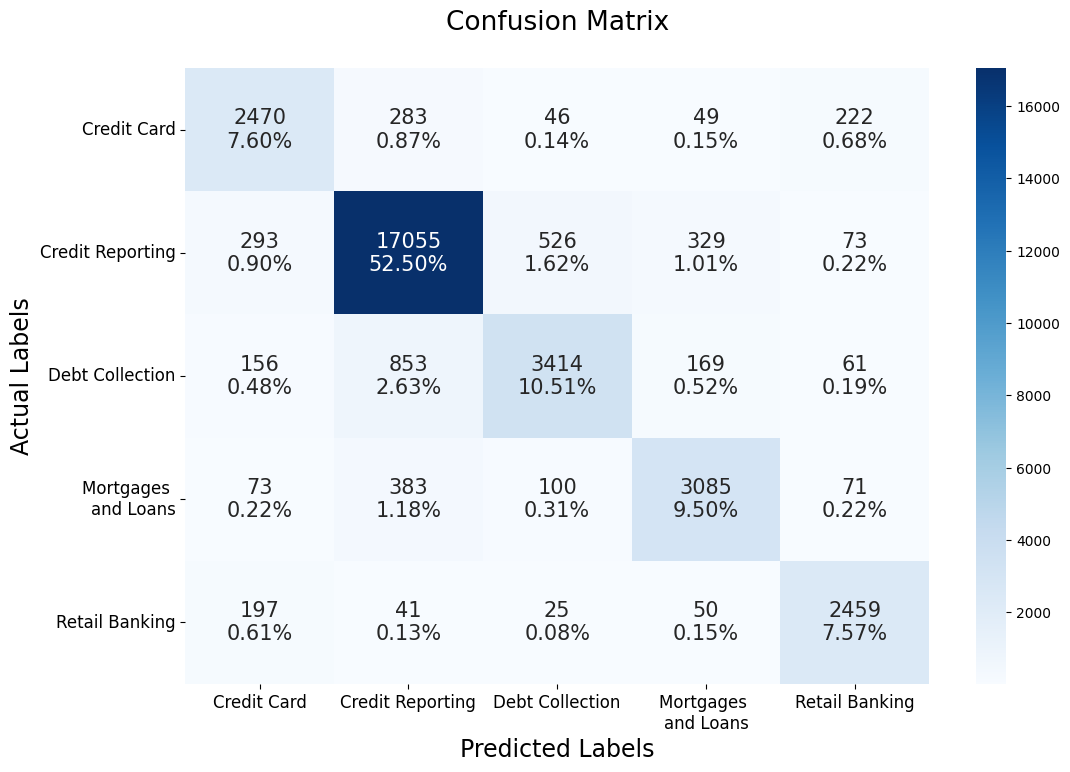

In [77]:
# Declaring function for plotting confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(model, test_data, test_labels):
    
    products = ['Credit Card', 'Credit Reporting', 'Debt Collection', 'Mortgages \nand Loans', 'Retail Banking']
        
    # Calculate predictions
    pred = model.predict(test_data)

# Declaring confusion matrix
    cm = confusion_matrix(np.argmax(np.array(test_labels),axis=1), np.argmax(pred, axis=1))
    
    # Heat map labels

    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(5,5)

# Plotting confusion matrix
    plt.figure(figsize=(12,8))
    
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=labels, annot_kws={"size": 15}, fmt = '',
                xticklabels = products,
                yticklabels = products)
    
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12, rotation = 'horizontal')
    plt.title('Confusion Matrix\n', fontsize=19)
    plt.xlabel('Predicted Labels', fontsize=17)
    plt.ylabel('Actual Labels', fontsize=17)
    
plot_cm(model, test_data, test_labels)

Model accuracy is **verified** with confusion matrix.

# References

1. NLP Implementation: https://www.kaggle.com/the0electronic0guy/nlp-with-disaster-tweets
2. NLP Book: Kulkarni, Akshay, and Adarsha Shivananda. Natural language processing recipes. Apress, 2019.
3. LSTM: https://www.kaggle.com/kritanjalijain/twitter-sentiment-analysis-lstm
4. Bi-LSTM: https://www.kaggle.com/kritanjalijain/twitter-sentiment-analysis-lstm-2#Bidirectional-LSTM-Using-NN
5. Bi-LSTM: https://www.kaggle.com/eashish/bidirectional-gru-with-convolution
6. Bi-LSTM: https://www.kaggle.com/victorbnnt/classification-using-lstm-85-accuracy
7. Imbalanced Datasets: https://towardsdatascience.com/yet-another-twitter-sentiment-analysis-part-1-tackling-class-imbalance-4d7a7f717d44
8. Multiclass Classification: https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a